### Table of metrics

In [13]:
import os
import pandas as pd
import re

def extract_metrics(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    
    train_acc = re.search(r'Train Accuracy:\s*(\d+\.\d+)', content)
    test_acc = re.search(r'Test Accuracy:\s*(\d+\.\d+)', content)
    
    train_acc = float(train_acc.group(1)) if train_acc else None
    test_acc = float(test_acc.group(1)) if test_acc else None
    
    weighted_avg_match = re.search(r'weighted avg\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)', content)
    
    if weighted_avg_match:
        weighted_avg_precision = float(weighted_avg_match.group(1))
        weighted_avg_recall = float(weighted_avg_match.group(2))
        weighted_avg_f1_score = float(weighted_avg_match.group(3))
    else:
        weighted_avg_precision = weighted_avg_recall = weighted_avg_f1_score = None
    
    return {
        'Filename': os.path.basename(file_path).replace('.txt', ''),
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Precision': weighted_avg_precision,
        'Recall': weighted_avg_recall,
        'F1-score': weighted_avg_f1_score
    }

def process_folder(folder_path, output_csv):
    results = []
    for file in os.listdir(folder_path):
        if file.endswith('.txt'):
            file_path = os.path.join(folder_path, file)
            results.append(extract_metrics(file_path))
    
    df = pd.DataFrame(results)
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)
    df.to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")
    print(df)
    return df

folder_path = 'output_results'  
output_csv = 'output_figures/aggregated_metrics.csv' 

df_metrics = process_folder(folder_path, output_csv)


Results saved to output_figures/aggregated_metrics.csv
          Filename  Train Accuracy  Test Accuracy  Precision  Recall  F1-score
0             NN12          0.9910         0.9848       0.99    0.98      0.98
1    NN12_filtered          0.9780         0.9562       0.96    0.96      0.96
2              NN5          0.9446         0.9340       0.93    0.93      0.93
3     NN5_filtered          0.9519         0.9292       0.93    0.93      0.93
4             RF12          1.0000         0.9933       0.99    0.99      0.99
5    RF12_filtered          1.0000         0.9850       0.98    0.98      0.98
6              RF5          1.0000         0.9910       0.99    0.99      0.99
7     RF5_filtered          1.0000         0.9764       0.98    0.98      0.98
8            SVM12          0.8994         0.8962       0.90    0.90      0.90
9   SVM12_filtered          0.8578         0.8509       0.85    0.85      0.85
10            SVM5          0.8801         0.8773       0.88    0.88      0.

### Accuracy plot

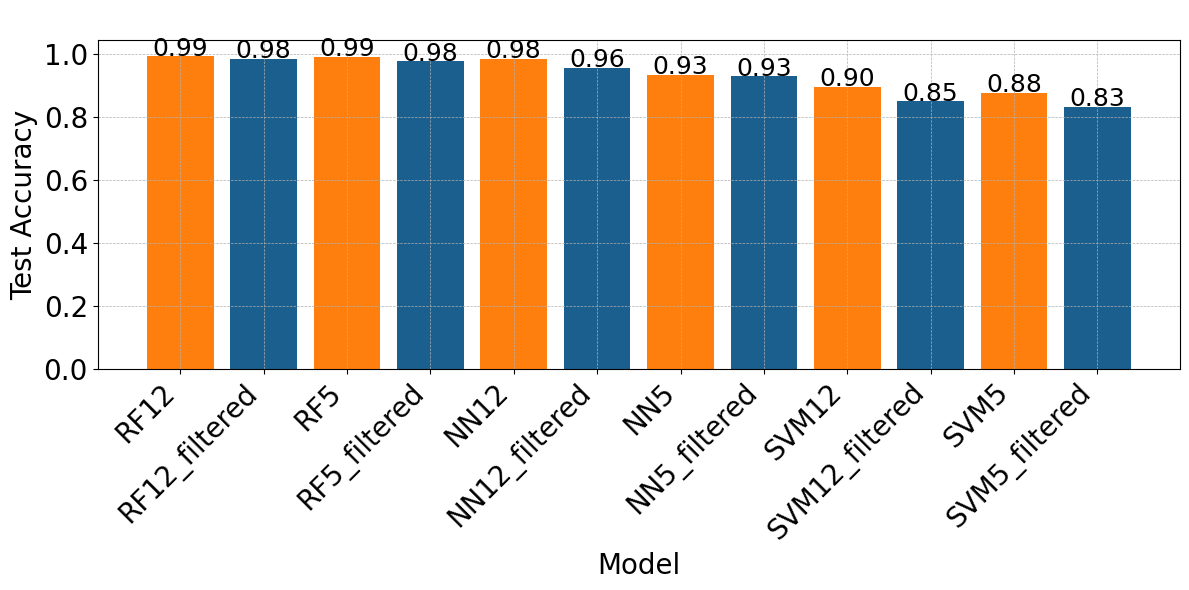

In [15]:
import matplotlib.pyplot as plt

def plot_test_accuracy(csv_file, output_image):
    df = pd.read_csv(csv_file)

    plt.figure(figsize=(12, 6))  
    colors = ['#1a5f8d' if 'filtered' in filename.lower() else '#ff7f0e' for filename in df['Filename']]
    
    plt.bar(df['Filename'], df['Test Accuracy'], color=colors)
    
    for i, v in enumerate(df['Test Accuracy']):
        plt.text(i, v + 0.001, f"{v:.2f}", ha='center', fontsize=18 ) 
    
    plt.xlabel('Model', fontsize=20 )
    plt.ylabel('Test Accuracy', fontsize=20)
    plt.title(' ', fontsize=20) 
    plt.grid(True, linestyle='--', linewidth=0.5)
    
    plt.xticks(rotation=45, ha='right', fontsize=20)  
    plt.yticks(fontsize=20)
    
    plt.tight_layout()
    os.makedirs(os.path.dirname(output_image), exist_ok=True)
    plt.savefig(output_image, dpi=300, bbox_inches='tight')
    plt.show()

output_image = 'output_figures/test_accuracy_plot.png'
plot_test_accuracy(output_csv, output_image)


### Misclassification plots

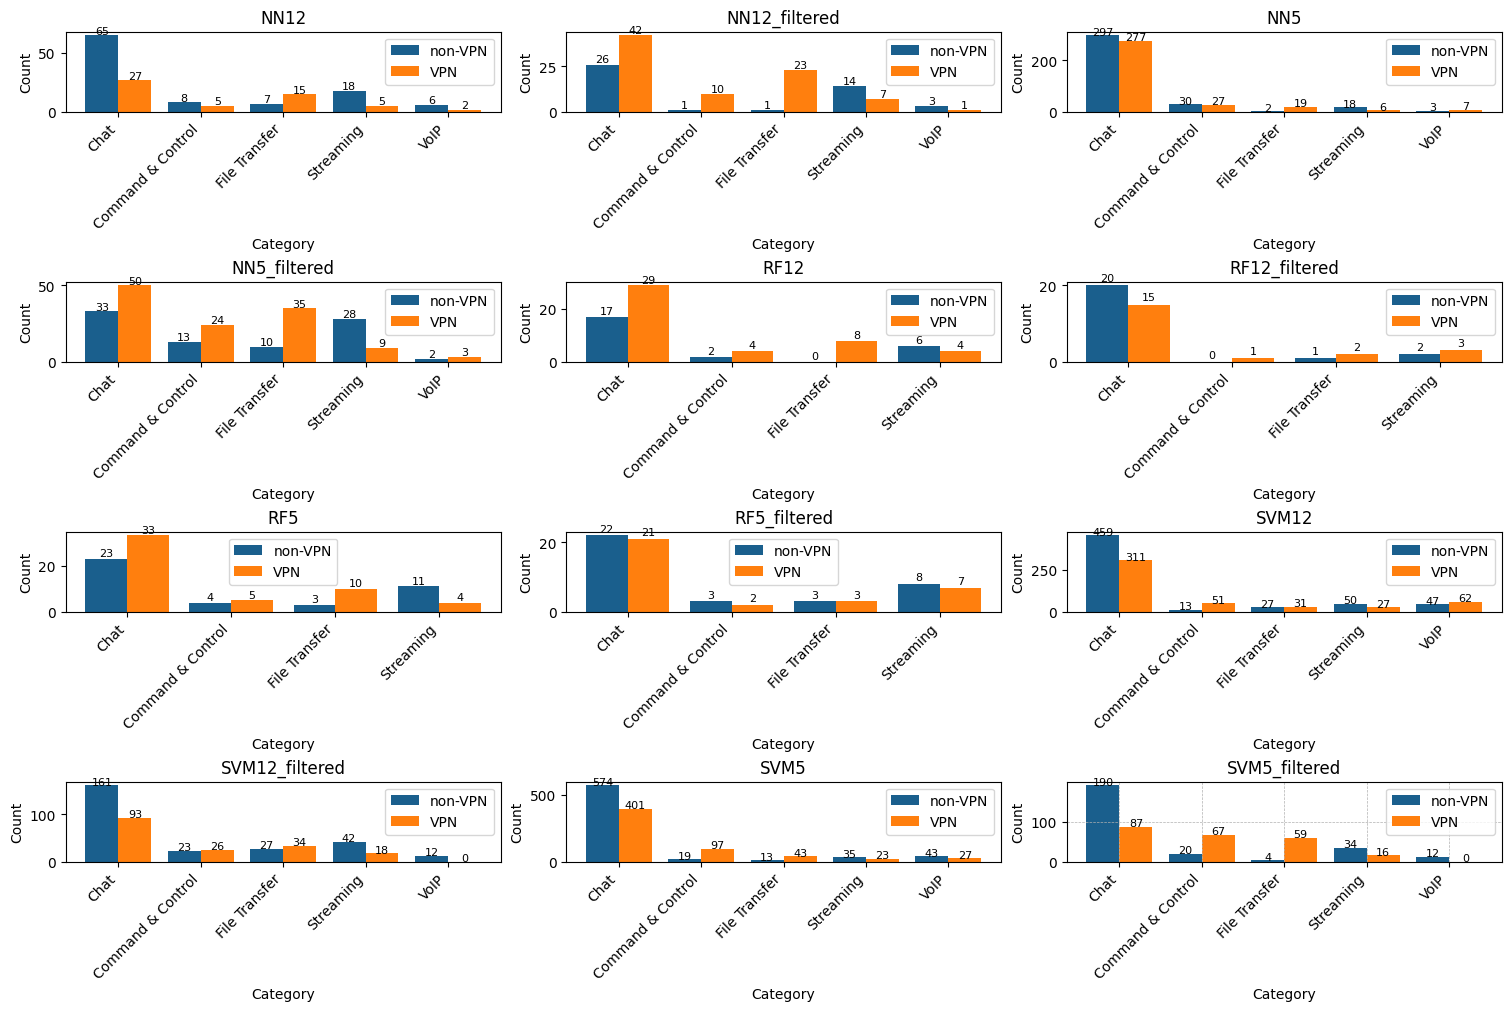

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def process_csv_files(folder_path, output_image):
    files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    num_files = len(files)
    if num_files == 0:
        print("No CSV files found in the folder.")
        return
    
    rows = int(np.ceil(np.sqrt(num_files)))
    cols = int(np.ceil(num_files / rows))
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10), constrained_layout=True)
    axes = np.array(axes).flatten()
    
    for ax, file in zip(axes, files):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        
        categories = df['category'].unique()
        x = np.arange(len(categories))
        width = 0.4
        
        counts_novpn = [df[(df['category'] == cat) & (df['true_label'] == 'NoVPN')]['count'].sum() for cat in categories]
        counts_vpn = [df[(df['category'] == cat) & (df['true_label'] == 'VPN')]['count'].sum() for cat in categories]
        
        ax.bar(x - width/2, counts_novpn, width, label='non-VPN', color='#1a5f8d')
        ax.bar(x + width/2, counts_vpn, width, label='VPN', color='#ff7f0e')
        
        ax.set_xticks(x)
        ax.set_xticklabels(categories, rotation=45, ha='right')
        ax.set_xlabel('Category')
        ax.set_ylabel('Count')
        plt.grid(True, linestyle='--', linewidth=0.5)
        ax.set_title(file.replace('.csv', ''))
        ax.legend()
        
        for i in range(len(categories)):
            ax.text(x[i] - width/2, counts_novpn[i] + 1, str(counts_novpn[i]), ha='center', fontsize=8)
            ax.text(x[i] + width/2, counts_vpn[i] + 1, str(counts_vpn[i]), ha='center', fontsize=8)
    
    for ax in axes[len(files):]:
        fig.delaxes(ax)
    
    plt.savefig(output_image, dpi=300, bbox_inches='tight')
    plt.show()

folder_path = 'output_results' 
output_image = 'multi_bar_charts_grid.png'  

process_csv_files(folder_path, output_image)


In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def process_csv_files(folder_path, output_folder):
    files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    num_files = len(files)
    if num_files == 0:
        print("No CSV files found in the folder.")
        return
    
    for file in files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        
        categories = df['category'].unique()
        x = np.arange(len(categories))
        width = 0.4
        
        counts_novpn = [df[(df['category'] == cat) & (df['true_label'] == 'NoVPN')]['count'].sum() for cat in categories]
        counts_vpn = [df[(df['category'] == cat) & (df['true_label'] == 'VPN')]['count'].sum() for cat in categories]
        
        plt.figure(figsize=(12, 6))
        plt.bar(x - width/2, counts_novpn, width, label='non-VPN', color='#1a5f8d')
        plt.bar(x + width/2, counts_vpn, width, label='VPN', color='#ff7f0e')
        
        plt.xticks(x, categories, rotation=30, ha='right', fontsize=24, wrap=True)
        plt.xlabel('Category', fontsize=24)
        plt.ylabel('Count', fontsize=24)
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.title('')
        plt.legend(fontsize=24)
        plt.yticks(fontsize=24)
        
        plt.tight_layout()
        
        for i in range(len(categories)):
            plt.text(x[i] - width/2, counts_novpn[i] + 1, str(counts_novpn[i]), ha='center', fontsize=20)
            plt.text(x[i] + width/2, counts_vpn[i] + 1, str(counts_vpn[i]), ha='center', fontsize=20)
        
        output_image = os.path.join(output_folder, f"{file.replace('.csv', '')}.png")
        plt.savefig(output_image, dpi=300, bbox_inches='tight')
        plt.close()
    
    print(f"Misclassification Figures saved in {output_folder}")

folder_path = 'output_results'  
output_folder = 'output_figures'  

process_csv_files(folder_path, output_folder)


Misclassification Figures saved in output_figures


### Comparison of Flow Counts 

In [12]:
import pandas as pd
import os

def summarize_datasets(df1, df2):
    summary1 = df1.groupby('category')['label'].value_counts().unstack(fill_value=0)
    summary1['Sum'] = summary1.sum(axis=1)
    summary1.index.name = None 
    
    summary2 = df2.groupby('category')['label'].value_counts().unstack(fill_value=0)
    summary2['Sum'] = summary2.sum(axis=1)
    summary2.index.name = None  
    
    df2_filtered = df2[df2['bidirectional_packets'] > 19]
    summary2_filtered = df2_filtered.groupby('category')['label'].value_counts().unstack(fill_value=0)
    summary2_filtered['Sum'] = summary2_filtered.sum(axis=1)
    summary2_filtered.index.name = None 
    
    reduction_percentage = ((summary2['Sum'] - summary2_filtered['Sum']) / summary2['Sum']) * 100
    
    summary1.columns = pd.MultiIndex.from_product([['Complete Flows'], summary1.columns])
    summary2.columns = pd.MultiIndex.from_product([['Active timeout 41'], summary2.columns])
    summary2_filtered = summary2_filtered[['Sum']]
    summary2_filtered.columns = pd.MultiIndex.from_product([['Active timeout 41'], ['Filtered Sum']])
    
    final_table = pd.concat([summary1, summary2, summary2_filtered], axis=1)
    final_table[('Active timeout 41', 'Reduction (%)')] = reduction_percentage
    
    return final_table

df1 = pd.read_csv('./VANT/CF/flows_extra_labelled_CF.csv',low_memory=False)
df2 = pd.read_csv('./VANT/WF/flows_extra_labelled_12.csv',low_memory=False)

final_summary = summarize_datasets(df1, df2)

print(final_summary)

output_folder = 'output_figures'
os.makedirs(output_folder, exist_ok=True)

output_path = os.path.join(output_folder, 'Comparison_of_Flow_Counts.csv')
final_summary.to_csv(output_path)

print(f"Summary results saved to: {output_path}")


                  Complete Flows             Active timeout 41               \
                           NoVPN  VPN    Sum             NoVPN   VPN    Sum   
Chat                        1244   57   1301              5928  5751  11679   
Command & Control          13591    8  13599             15961  1624  17585   
File Transfer              16420   10  16430             17588   378  17966   
Streaming                   1759    5   1764              3334   160   3494   
VoIP                         318  299    617               786   437   1223   

                                              
                  Filtered Sum Reduction (%)  
Chat                     10259     12.158575  
Command & Control         1470     91.640603  
File Transfer              805     95.519314  
Streaming                 1841     47.309674  
VoIP                       242     80.212592  
Summary results saved to: output_figures\Comparison_of_Flow_Counts.csv
